# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
pip install scikit-learn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (1.0.2)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt
import math


import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from sklearn.neighbors import NearestNeighbors # for kNN
from sklearn.neighbors import KNeighborsClassifier

from IPython.display import display

# import sys and insert code to ignore warnings 
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(5)

,gender,age,income,family_members,insurance_benefits
522,1,46.0,20700.0,1,1
2695,1,33.0,37500.0,4,0
2069,1,24.0,42000.0,3,0
1748,1,20.0,28100.0,1,0
2775,1,41.0,42400.0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null float64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype('int16')

In [8]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null int16
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(1), int16(1), int64(3)
memory usage: 166.1 KB


In [9]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


We note no missing values, the balance of male to female is almost equal, mean and median age are 30 with a min of 18 and a max of 65. The income varies from 5K to almost 80K with close mean/median of about 40K. The mean/median number of family members is 1. All of this info appears reasonable.

We note many insured don't have any family members. We will investigate this further to make sure there are no problems.

We will also dive deeper into the insurance benefit info.

In [10]:
# investigate rows where family members == 0
absent_family = df[df.family_members == 0]
absent_family.describe()

,gender,age,income,family_members,insurance_benefits
count,1513.000000,1513.000000,1513.000000,1513.0,1513.000000
mean,0.495043,30.977528,40273.562459,0.0,0.159947
std,0.500141,8.488680,9889.134867,0.0,0.490177
min,0.000000,18.000000,7400.000000,0.0,0.000000
25%,0.000000,24.000000,33700.000000,0.0,0.000000
50%,0.000000,30.000000,40700.000000,0.0,0.000000
75%,1.000000,37.000000,46700.000000,0.0,0.000000
max,1.000000,62.000000,75200.000000,0.0,4.000000


We find about 30% of our sample have not listed any additional family_members, but the metrics for this sample (gender, age, income, insurance benefits) are comparable with the larger sample, so we don't see any issues.

In [11]:
# investigate percent of members who recieved benefits 
pct = (len(df[df.insurance_benefits != 0]))/len(df)
print("Percent of members who received benefits: {:.2%}".format(pct))
print('This is good information to keep in mind for our analysis since it indicates an imbalance.')

Percent of members who received benefits: 11.28%
This is good information to keep in mind for our analysis since it indicates an imbalance.


## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

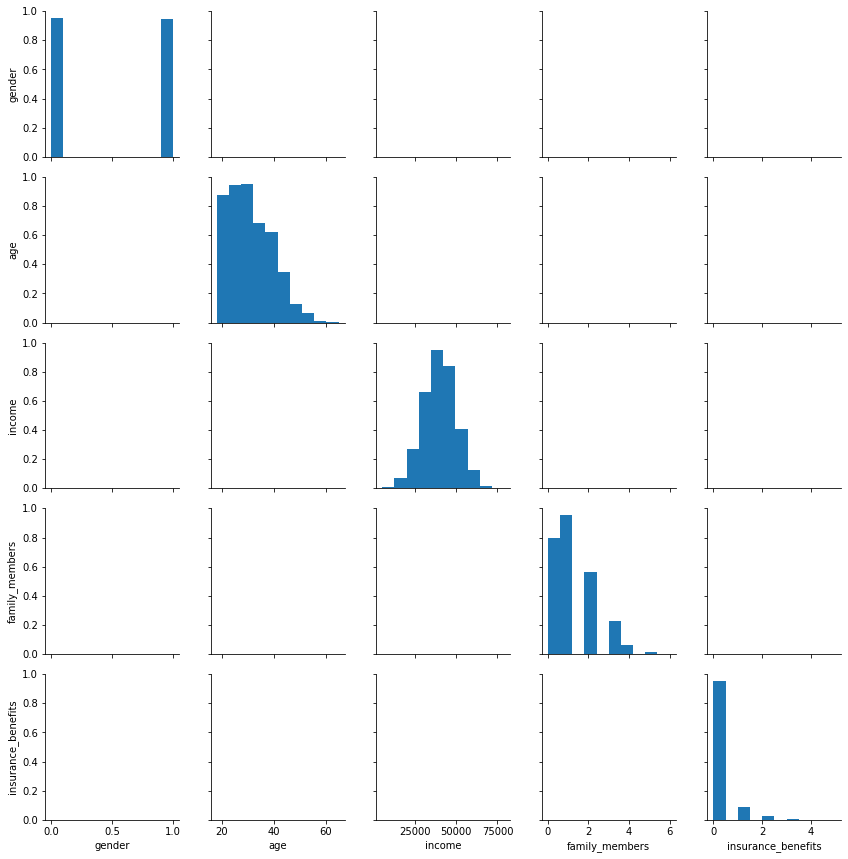

In [12]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [14]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    
    features = df[feature_names] # 
    target = df.drop(columns = ['insurance_benefits'], axis=1) #
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(features)
    # class sklearn.neighbors.NearestNeighbors(*, n_neighbors=5, radius=1.0, algorithm='auto', 
    # leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=None) Defaults
    # metric either “euclidean” or “manhattan”

    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [15]:
df.sample(5)

,gender,age,income,family_members,insurance_benefits
2260,0,26,30600.0,2,0
4577,1,31,44600.0,2,0
3761,1,33,54000.0,3,0
3816,1,36,50700.0,1,0
813,1,18,35600.0,0,0


In [16]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [17]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1581,0.0,0.369231,0.726582,0.166667,0
3308,0.0,0.492308,0.589873,0.166667,0
3350,1.0,0.338462,0.491139,0.666667,0
3961,0.0,0.430769,0.525316,0.166667,0
1709,1.0,0.446154,0.708861,0.333333,0


Now, let's get similar records for a given one for every combination.

In [18]:
# select a record number to use with the nearest neighbor call
# (we selected record # 1127 randomly) 
df.iloc[1127][feature_names]

gender                1.0
age                  35.0
income            30700.0
family_members        1.0
Name: 1127, dtype: float64

In [19]:
# combination of data not scaled, Manhattan distance metric
get_knn(df,1127,10,'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
1127,1,35,30700.0,1,0,0.0
126,0,35,30700.0,1,0,1.0
696,1,34,30700.0,0,0,2.0
230,0,35,30700.0,0,0,2.0
1792,1,33,30700.0,1,0,2.0
3818,1,37,30700.0,1,0,2.0
3450,0,37,30700.0,3,0,5.0
672,1,30,30700.0,1,0,5.0
576,1,40,30700.0,3,0,7.0
2569,0,30,30700.0,4,0,9.0


In [20]:
# combination of data not scaled, Euclidean distance metric
get_knn(df,1127,10,'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
1127,1,35,30700.0,1,0,0.000000
126,0,35,30700.0,1,0,1.000000
696,1,34,30700.0,0,0,1.414214
230,0,35,30700.0,0,0,1.414214
3818,1,37,30700.0,1,0,2.000000
1792,1,33,30700.0,1,0,2.000000
3450,0,37,30700.0,3,0,3.000000
672,1,30,30700.0,1,0,5.000000
576,1,40,30700.0,3,0,5.385165
2569,0,30,30700.0,4,0,5.916080


In [21]:
# combination of data scaled, Euclidean distance metric
get_knn(df_scaled,1127,10,'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
1127,1.0,0.538462,0.388608,0.166667,0,0.000000
1934,1.0,0.553846,0.382278,0.166667,0,0.016636
2743,1.0,0.523077,0.397468,0.166667,0,0.017754
2008,1.0,0.538462,0.412658,0.166667,0,0.024051
1630,1.0,0.523077,0.410127,0.166667,0,0.026453
1275,1.0,0.523077,0.367089,0.166667,0,0.026453
4828,1.0,0.523077,0.365823,0.166667,0,0.027492
4220,1.0,0.553846,0.364557,0.166667,0,0.028550
2385,1.0,0.553846,0.413924,0.166667,0,0.029624
1792,1.0,0.507692,0.388608,0.166667,0,0.030769


In [22]:
# combination of data scaled, Manhattan distance metric
get_knn(df_scaled,1127,10,'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
1127,1.0,0.538462,0.388608,0.166667,0,0.000000
1934,1.0,0.553846,0.382278,0.166667,0,0.021714
2008,1.0,0.538462,0.412658,0.166667,0,0.024051
2743,1.0,0.523077,0.397468,0.166667,0,0.024245
1792,1.0,0.507692,0.388608,0.166667,0,0.030769
3818,1.0,0.569231,0.388608,0.166667,0,0.030769
1738,1.0,0.538462,0.355696,0.166667,0,0.032911
3334,1.0,0.569231,0.393671,0.166667,0,0.035833
1630,1.0,0.523077,0.410127,0.166667,0,0.036904
1275,1.0,0.523077,0.367089,0.166667,0,0.036904


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

As expected, when the data is not scaled the features with the greater number (in this case income) are weighted more than features with a small range (binary features such as gender and family_members). 

Running the algorithm on an unscaled df results in top matches having the exact same income, but gender and family_members vary. This is inaccurate. Our results should not focus on income as the primary feature to discern similarity.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

There is notable similarity between both methods when we compare runs of scaled data and also when we compare runs of unscaled data. This is expected. The top ten of the unscaled groups, where income is weighted so heavily, match almost perfectly (there is a minor swap of one place). The scaled runs are also very similar, but we observe only 7 of the top ten match (again, there are some swaps in order). This also makes sense because the scaled data allows for a better alogorithmic analysis.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [23]:
# calculate the targets scaled and unscaled
df['insurance_benefits_received'] = df['insurance_benefits'] >= 1
df.loc[df['insurance_benefits_received'] == True, 'insurance_benefits_received'] = 1
df.loc[df['insurance_benefits_received'] == False, 'insurance_benefits_received'] = 0
df_scaled['insurance_benefits_received'] = df_scaled['insurance_benefits'] >= 1
df_scaled.loc[df['insurance_benefits_received'] == True, 'insurance_benefits_received'] = 1
df_scaled.loc[df['insurance_benefits_received'] == False, 'insurance_benefits_received'] = 0
features = df.drop(['insurance_benefits_received', 'insurance_benefits'], axis=1)
target = df['insurance_benefits_received']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.3, random_state=0)
print('Training:', features_train.shape, target_train.shape)
print('Testing:', features_test.shape, target_test.shape)

Training: (3500, 4) (3500,)
Testing: (1500, 4) (1500,)


In [24]:
# check for the class imbalance with value_counts()
print(df['insurance_benefits_received'].value_counts())
print(df_scaled['insurance_benefits_received'].value_counts())

0    4436
1     564
Name: insurance_benefits_received, dtype: int64
0    4436
1     564
Name: insurance_benefits_received, dtype: int64


We observe an imbalance data in the insurance_benefits_received so we can not use accuracy to evaluate model. Using accuracy will result in skewed result. We can use f1 score, which combines precision and recall. We can also use the confusion matrix.

In [25]:
# scale data
scaler = sklearn.preprocessing.MaxAbsScaler()
scaler.fit(features_train) # fit to training data
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [26]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cmpct = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all') # if want %
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    print(cm)
    print(cmpct)
    # added plot for conf_matrix
    plt.figure(figsize=(9,9))
    sns.heatmap(cmpct, annot=True, fmt=".3f", linewidths=0.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Confusion Matrix' 
    plt.title(all_sample_title, size = 15);
    plt.show()

In [27]:
# set up the knn algorithm
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(features_train, target_train)

KNeighborsClassifier(n_neighbors=3)

F1: 0.44
Confusion Matrix
[[1324   22]
 [ 105   49]]
[[0.88266667 0.01466667]
 [0.07       0.03266667]]


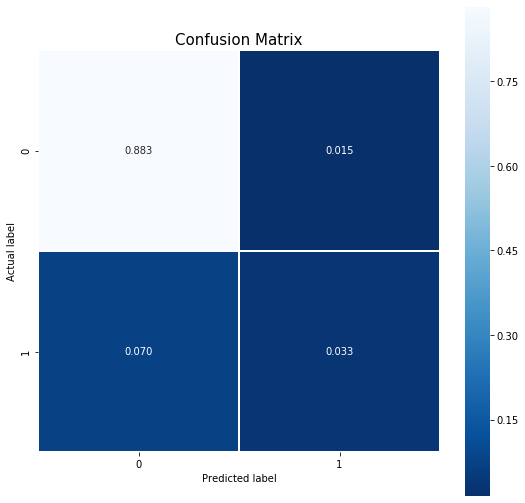

In [28]:
# evaluate dummy model
eval_classifier(target_test, knn.predict(features_test))

We note poor performance of our model using kNN = 3. The F1 score is only 0.44. The true positives prediction is fair at close to 0.9, but the true negative score is quite low.

In [29]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    # sample one value from binomial distribution
    return rng.binomial(n=1, p=P, size=size)

The probability: 0.00
F1: 0.00
Confusion Matrix
[[4436    0]
 [ 564    0]]
[[0.8872 0.    ]
 [0.1128 0.    ]]


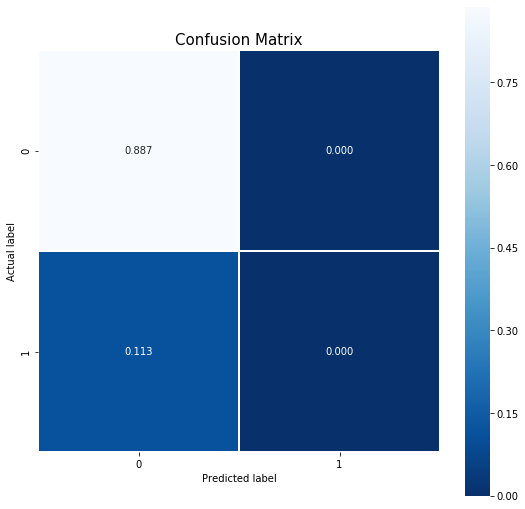


The probability: 0.11
F1: 0.12
Confusion Matrix
[[3957  479]
 [ 497   67]]
[[0.7914 0.0958]
 [0.0994 0.0134]]


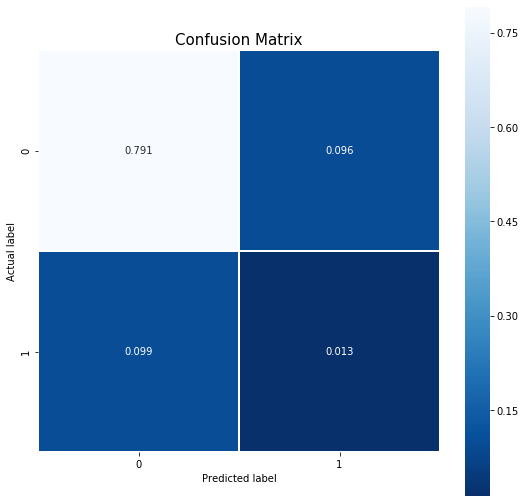


The probability: 0.50
F1: 0.20
Confusion Matrix
[[2280 2156]
 [ 265  299]]
[[0.456  0.4312]
 [0.053  0.0598]]


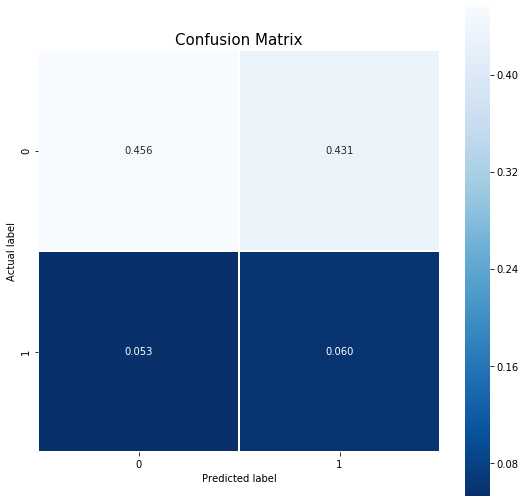


The probability: 1.00
F1: 0.20
Confusion Matrix
[[   0 4436]
 [   0  564]]
[[0.     0.8872]
 [0.     0.1128]]


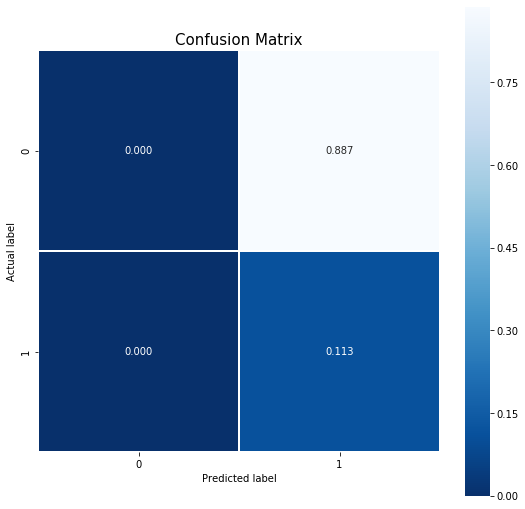

In [30]:
# df['insurance_benefits_received'].sum() / len(df) is the prob of paying any insurance benefit
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:
    
    print(f'The probability: {P:.2f}')
    # used df['insurance_benefits_received'] to reflect eval_classifier 
    y_pred_rnd = rnd_model_predict(P, df['insurance_benefits_received'].shape[0])
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

As expected, the F1 scores are pretty low (the highest is 0.20) for these dummy models.

In [31]:
#K-NeighborsClassifier for k in range 10 + f1_score. Unscaled data
print('\nUnscaled data used for kNN')
unscaled_f1 = []
for k in range(1,11):
    knc = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knc.fit(features_train, target_train)
    knc_pred = knc.predict(features_test)
    f1_score = sklearn.metrics.f1_score(target_test, knc_pred)
    unscaled_f1.append(f1_score)
    print(f'N_neighbors: {k}, F1: {f1_score:.2f}')


Unscaled data used for kNN
N_neighbors: 1, F1: 0.61
N_neighbors: 2, F1: 0.44
N_neighbors: 3, F1: 0.44
N_neighbors: 4, F1: 0.20
N_neighbors: 5, F1: 0.20
N_neighbors: 6, F1: 0.09
N_neighbors: 7, F1: 0.16
N_neighbors: 8, F1: 0.10
N_neighbors: 9, F1: 0.11
N_neighbors: 10, F1: 0.00


In [32]:
#K-NeighborsClassifier for k in range 10 + f1_score. Scaled data
print('\nScaled data used for kNN')
scaled_f1 = []
for k in range(1,11):
    knc = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knc.fit(features_train_scaled, target_train)
    knc_pred = knc.predict(features_test_scaled)
    f1_score = sklearn.metrics.f1_score(target_test, knc_pred)
    scaled_f1.append(f1_score)
    print(f'N_neighbors: {k}, F1: {f1_score:.2f}')


Scaled data used for kNN
N_neighbors: 1, F1: 0.95
N_neighbors: 2, F1: 0.92
N_neighbors: 3, F1: 0.94
N_neighbors: 4, F1: 0.89
N_neighbors: 5, F1: 0.91
N_neighbors: 6, F1: 0.89
N_neighbors: 7, F1: 0.91
N_neighbors: 8, F1: 0.89
N_neighbors: 9, F1: 0.91
N_neighbors: 10, F1: 0.90


We use the f1 score, reflecting precision and recall, to measure kNN runs. We observe the kNN algorithm does indeed perform better than the dummy model, where we reached a maximum f1 score of 0.20. For the scaled data we reach a maximum f1 score of .61 when kNN = 1, and .44 when kNN = 1 or kNN = 2. The results of the kNN for the scaled data are impressive, >= 0.89 for kNN 1 - 10. The highest value, 0.95 occurs when kNN = 1, but when kNN = 3 the f1 = .94, still impressive. 

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [33]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        # adding the unities
        # note need to add column so matrix multiplication works 
        X2 = np.append(np.ones([len(X), 1]), X, axis=1) 
        # use the weight formula from above
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):       
        # adding the unities
        # note need to add column so matrix multiplication works 
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        # use the formula for predicted values formula from above
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [34]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [35]:
# results with unscaled data

print('Results with unscaled data\n')

X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print('Linear Regression weights:\n', lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

Results with unscaled data

Linear Regression weights:
 [-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [36]:
# results with scaled data

print('Results with scaled data\n')

X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print('Linear Regression weights:\n', lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

Results with scaled data

Linear Regression weights:
 [-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


In [37]:
# results with unscaled, stratified data

print('Results with scaled data\n')

X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = df['insurance_benefits_received'], random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print('Linear Regression weights:\n', lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

Results with scaled data

Linear Regression weights:
 [-9.65464676e-01  2.36997150e+00  6.34628613e-03  7.22175049e-04
 -7.83293864e-02]
RMSE: 0.34
R2: 0.65


In [38]:
# results with scaled, stratified data

print('Results with scaled data\n')

X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = df['insurance_benefits_received'], random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print('Linear Regression weights:\n', lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

Results with scaled data

Linear Regression weights:
 [-9.65464676e-01  2.36997150e+00  6.34628613e-03  7.22175049e-04
 -7.83293864e-02]
RMSE: 0.34
R2: 0.65


Our comparison of scaled and unscaled dataframes ends up with about the same RMSE and R2 values. The RMSE score measured around 34%, indicating a high percentage of errors made by the model in predictions. The R2 score, at 66% suggests a moderate to poor fit. A score of 100% would indicate a perfect match between predicted and actual target values.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [39]:
# create df with 4 features
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [40]:
# create a matrix X to compare with transformed
Xoriginal = df_pn.to_numpy()

In [41]:
# create a matrix X
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [42]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [43]:
# create inverse of P
inv_P = np.linalg.inv(P)
inv_P

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [44]:
# multiply P by the inverse to check for invertibility
P.dot(inv_P).round(1)

array([[ 1.,  0., -0., -0.],
       [ 0.,  1., -0.,  0.],
       [ 0.,  0.,  1., -0.],
       [-0., -0., -0.,  1.]])

While we note some minor fluctuations from 0 and 1, they can be explained by the way float math is calculated. All the values on the diagonal are 1 and those not on the diagonal are very, very close to 0. 

The matrix $P$ is invertible. inv(P) did not return an error here, so P is confirmed to be invertible.

In [45]:
# print shapes of X and P
X.shape

(5000, 4)

In [46]:
# print shape of P
P.shape

(4, 4)

In [47]:
# use matrix multiplication with order of shapes (col=row)
# to transform data (obfuscate the data by multiplying by P)
Xprime = X.dot(P)
Xprime.shape

(5000, 4)

Can you guess the customers' ages or income after the transformation?

In [48]:
# print obfuscated data
Xprime

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

We would be able to use the obfuscated data to guess customer ages or income.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

$$
X' = X \times P 
$$

$$ 
X' \times P^{-1} = X 
$$


$$ 
X = X' \times P^{-1}
$$

In [49]:
# recover original data from Xprime
Xreverse = Xprime.dot(np.linalg.inv(P))
Xreverse

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [ 1.67952800e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-6.23021448e-13,  2.90000000e+01,  2.10000000e+04,
        -2.03032656e-13],
       ...,
       [ 1.57996161e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

In [50]:
# verify match with pre transformation matrix
Xoriginal

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [51]:
rows = [277, 1202, 2345]
print('Verify original and reversed values match')
print('gender    age    income    family_members')
for x in rows:
    print('\noriginal', Xoriginal[x,:])
    print('transformed', Xprime[x,:])
    print('reversed', Xreverse[x,:])

Verify original and reversed values match
gender    age    income    family_members

original [1.00e+00 3.20e+01 4.32e+04 0.00e+00]
transformed [ 5538.29656276 19488.33131078 16043.68971523 40062.09894406]
reversed [ 1.00000000e+00  3.20000000e+01  4.32000000e+04 -7.45166047e-13]

original [0.00e+00 2.30e+01 3.45e+04 2.00e+00]
transformed [ 4423.37413655 15562.39969471 12810.92487757 31991.92607174]
reversed [1.15555714e-12 2.30000000e+01 3.45000000e+04 2.00000000e+00]

original [0.00e+00 2.50e+01 4.94e+04 1.00e+00]
transformed [ 6331.81175299 22274.27865245 18336.89430384 45802.06929547]
reversed [4.76452781e-12 2.50000000e+01 4.94000000e+04 1.00000000e+00]


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

These slight differences between the original values and reversed values are likely due to float math calculations.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

$w$ and $w_P$ will be linked by the inverse of matrix P, as in the formula $w_P = [P]^{-1}w$. The predicted values with $w_P$ will be the inverse of the corresponding P value matrix multiplied by w. The RMSE and R2 should remain stable for both runs of the algorithm (with and without obfuscated data). 

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>

**Analytical proof**


$$
w = (X^T X)^{-1} X^T y
$$

$$
w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

$$
w_P = [(P^TX^T)XP)]^{-1} (XP)^T y
$$

$$
w_P = [P^T(X^TX)P]^{-1} (P^TX^T) y
$$

$$
w_P = [P^T]^{-1}[(X^TX)]^{-1}[P]^{-1} P^TX^T y
$$

$$
w_P = [(X^TX)]^{-1}[P]^{-1} (X^T) y
$$

$$
Pw_P = P[(X^TX)]^{-1}[P]^{-1} (X^T) y
$$

$$
Pw_P = (X^TX)^{-1}(X^T) y
$$

So now we can substitute $$
w = (X^T X)^{-1} X^T y
$$
and find that

$$
Pw_P = w \quad \Rightarrow \quad  ([P]^{-1})Pw_P = [P]^{-1}w \quad \Rightarrow \quad w_P = [P]^{-1}w
$$

So with our formula for predictions transformed for $w_P$

$$
y = Xw \quad \Rightarrow \quad y_P = X_Pw_P = XP[P]^{-1}w = Xw \quad \Rightarrow \quad y_P = Xw
$$

Using $X_P$ = XP in the formula above we demonstrate that the predictions of the original dataset and the obfuscated dataset will match.

<div class="alert alert-warning">
<b>Reviewer's comment V2</b>

Ok, almost, but not quite! Up to this line everything is correct:
    
$$
w_P = [P^T(X^TX)P]^{-1} (P^TX^T) y
$$
    
But in the next line you forgot to switch the order when applying inversion:
    
$$
w_P = [P^T]^{-1}[(X^TX)]^{-1}[P]^{-1} P^TX^T y
$$
should be 
    
$$
w_P = [P]^{-1}[(X^TX)]^{-1}[P^T]^{-1} P^TX^T y
$$
    
Then $P^T$ and its inverse kill each other off, and we immediately get that $$w_P = P^{-1} w$$

</div>

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [52]:
class MyLinearRegression2:
    
    def __init__(self, data):
        self.weights = None
        self.data = data
        
    def fit(self, X, y):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        self.weights = weights[1:]
        self.bias = weights[0]

    def predict(self, X):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X.dot(self.weights) + self.bias
        return y_pred

In [53]:
# MyLinearRegression2 on the normal dataset.
X = Xoriginal
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression2(X)

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 1.64272726e-02  3.57495491e-02 -2.60743659e-07 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [54]:
# MyLinearRegression2 on the obfuscated dataset.
X = Xprime
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression2(Xprime)

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)


[-0.05791721 -0.01546567  0.09871889 -0.02397536]
RMSE: 0.34
R2: 0.66


We observe no difference in the RMSE and R2 scores for both linear regression models (with and without transformation). The quality of the linear regression remains the same after transformation.

# Conclusions

Task 1: We imported and inspected the data. We did note an imbalance of about 1:9 for those receiving benefits. We discovered scaling the data dramatically changed the results for both distance metrics with runs because the unscaled data gave too much weight to the income, and perhaps age, features over the bianary features. 

Task 2: When we compared f1 scores on dummy/random and scaled/unscaled kNN classification, we discovered our scaled kNN classification to perform the best. In fact, we reached a f1 of 0.95 and 0.94 on scaled data with kNN 1 and kNN = 3, respectively.

Task 3: The linear regression model demonstrated lower R2 and RMSE scores (34% and 66%). We did find that scaling data made no difference in RMSE or R2 scores.

Task 4: We obfuscated the data and demonstrated the invertibility of our data matrix by proofs and practical demonstrations (lr runs and printing row information for df before, df obfuscated, df reversed to original). While there were minor math differences, they are easily explained by float math. We clearly demonstrated obfuscating the data does not impact or change the predictive quality of the model.

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>

## References
[LR from scratch](https://kenzotakahashi.github.io/linear-regression-from-scratch-in-python.html)

[Fitting knn model](https://stats.stackexchange.com/questions/349842/why-do-we-need-to-fit-a-k-nearest-neighbors-classifier)

[Fix error: last 2 dimensions of array must be square](https://flutterq.com/solved-linalgerror-last-2-dimensions-of-the-array-must-be-square/)

[F1 score explained](https://www.mikulskibartosz.name/f1-score-explained/)